In [1]:
%matplotlib inline

In [2]:
# This part is from https://mne.tools/stable/auto_tutorials/machine-learning/plot_sensors_decoding.html 

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP) #a lot of these are wrapper functions to get it into shape to use the sk functions directly

In [3]:
#Loading sample data and epochs. But only taking two conditions: auditory left, visual left - to make sure
#we have a binary dataset
data_path = sample.data_path()

subjects_dir = data_path + '/subjects'
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
tmin, tmax = -0.200, 0.500
event_id = {'Auditory/Left': 1, 'Visual/Left': 3}  # just use two
raw = mne.io.read_raw_fif(raw_fname, preload=True)

# The subsequent decoding analyses only capture evoked responses, so we can
# low-pass the MEG data. Usually a value more like 40 Hz would be used,
# but here low-pass at 20 so we can more heavily decimate, and allow
# the examlpe to run faster. The 2 Hz high-pass helps improve CSP.
raw.filter(2, 20)
events = mne.find_events(raw, 'STI 014')

# Set up pick list: EEG + MEG - bad channels (modify to your needs)
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=('eeg', 'eog'), baseline=(None, 0.), preload=True,
                    reject=dict(eeg=150e-6, eog=150e-6), decim=10)
epochs.pick_types(meg=False, eeg=True, exclude='bads')  # remove stim and EOG
del raw

Opening raw data file C:\Users\louis\mne_data\MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 993 samples (1.653 sec)

320 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
Not setting m

In [4]:
X = epochs.get_data()  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: Audio left or right

In [5]:
X.shape

(123, 59, 43)

In [6]:
epochs.info

<Info | 19 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 59 EEG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 2.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 20.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 59
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: []
 sfreq: 60.1 Hz
>

In [7]:
y

array([3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3,
       1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1,
       3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1], dtype=int64)

In [8]:
#since y is 1s and 3s, we make sure it is 1s and 0s
y[y==3] = 0

In [9]:
y

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1], dtype=int64)

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=124)

In [23]:
#naming convention clf
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression()))
#wrapping LR in LM (a mne-python thing to help us getting the coef later)

In [24]:
#just a pipline
clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearmodel', LinearModel(model=LogisticRegression()))])

In [25]:
#for each time point in epoch, it will run the clf function - using the roc score, to get a classification score
# for each time point in the evoked signal => so we will get 43 classifications out (one for each time point)
time_decod = SlidingEstimator(clf, scoring='roc_auc')

#classifying whether the condition is auditory/left or visual/left for the same time point.

In [26]:
X.shape
#epochs/trials, channels, time

(123, 59, 43)

In [27]:
#multiscore, because we use the time_decode object - other than that, the same as in the intro_sklearn
scores = cross_val_multiscore(time_decod, X, y, cv=cv)
#classifying whether the condition is auditory/left or visual/left for the same time point.
#getting a fit for each fold

100%|██████████| Fitting SlidingEstimator : 43/43 [00:00<00:00,   71.32it/s]
100%|██████████| Fitting SlidingEstimator : 43/43 [00:00<00:00,   52.76it/s]
100%|██████████| Fitting SlidingEstimator : 43/43 [00:00<00:00,   72.08it/s]
100%|██████████| Fitting SlidingEstimator : 43/43 [00:00<00:00,   69.60it/s]
100%|██████████| Fitting SlidingEstimator : 43/43 [00:00<00:00,   72.34it/s]


In [28]:
#Five scores (one for each fold) with 43 time points
scores.shape

(5, 43)

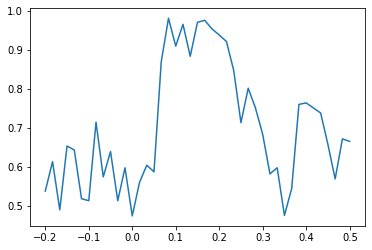

In [29]:
#plotting accuracy over time - as soon as we see the stimuli onset, we are pretty good at classifying
# whether they are listening or seeing something (just after 0 on x-axis.)
#y-axis = roc score (1 is perfect), x-axis = time
plt.plot(epochs.times, scores.mean(axis=0));

In [30]:
clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression()))


In [31]:
time_decod = SlidingEstimator(clf, scoring='roc_auc')

In [32]:
time_decod.fit(X, y)
#fitting once (for each time point)(=no cross-validation) to get the coefficients

100%|██████████| Fitting SlidingEstimator : 43/43 [00:00<00:00,   71.40it/s]


<SlidingEstimator(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearmodel', LinearModel(model=LogisticRegression()))]),
         n_jobs=1, scoring='roc_auc', verbose=None, fitted with 43 estimators>

In [33]:
#inverse = transforming back to the ERP values = same scale as the data (from z-scores, if set to false, we would just get the z-score)
coef = get_coef(time_decod, 'filters_', inverse_transform=True)

In [34]:
#for each channel, we have a coefficient over time (not per trial - since we have it for evoked)
coef.shape

(59, 43)

In [35]:
#evoked object with coef as data - taking epoch and first time point from epoch object
evoked_coef = mne.EvokedArray(coef,
                              epochs.info,
                              tmin=epochs.times[0])

No projector specified for this dataset. Please consider the method self.add_proj.


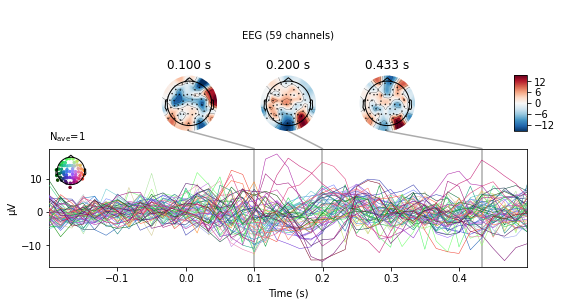

In [36]:
#plotting coefs
evoked_coef.plot_joint(); 
#needed if you want to interpret what is going on in your "black box"
#the warning can be ignored since we don't have real data

#That's all it takes to do machine learning on EEG data!

## Another classifier - naive gaussian bayes
Good at predicting whether something is spam or not.
Assumes all features are independent. For some problems it might be a good idea, for others not. Can be very good for MEG data with different sensor types (they are completely different values)

In [37]:
from sklearn.naive_bayes import GaussianNB

In [38]:
clf_nb = make_pipeline(StandardScaler(), GaussianNB())

In [39]:
time_decod_nb = SlidingEstimator(clf_nb, scoring='roc_auc')

In [40]:
scores_nb = cross_val_multiscore(time_decod_nb, X, y, cv=cv)

100%|██████████| Fitting SlidingEstimator : 43/43 [00:00<00:00,  570.21it/s]
100%|██████████| Fitting SlidingEstimator : 43/43 [00:00<00:00,  643.51it/s]
100%|██████████| Fitting SlidingEstimator : 43/43 [00:00<00:00,  634.05it/s]
100%|██████████| Fitting SlidingEstimator : 43/43 [00:00<00:00,  355.19it/s]
100%|██████████| Fitting SlidingEstimator : 43/43 [00:00<00:00,  346.78it/s]


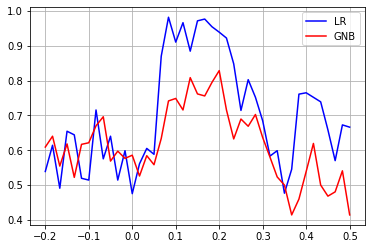

In [41]:
#accuracy over time - how well we can separate two classes over time
plt.plot(epochs.times, scores.mean(axis=0), 'b', label='LR')
plt.plot(epochs.times, scores_nb.mean(axis=0), 'r', label='GNB');
plt.legend();
plt.grid();

#it is worse than LR (logistic regression)


In [44]:
scores.mean()
scores.mean(axis=0).max() #mean across time axis, picking out the max value

0.9818181818181818

In [45]:
scores_nb.mean(axis=0).max()

0.8285714285714285

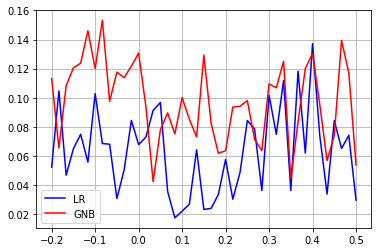

In [46]:
plt.plot(epochs.times, scores.std(axis=0), 'b', label='LR')
plt.plot(epochs.times, scores_nb.std(axis=0), 'r', label='GNB')
plt.legend();
plt.grid();